In [ ]:
# # 데이터 압축 풀기
# !tar -xvJf /workspace/mvtec_anomaly_detection.tar.xz -C /workspace/data/MVTecAD

# **0. 기본 설정**

In [1]:
import os
import random
import numpy as np
import torch

In [2]:
import sys, os
sys.path.append(os.path.abspath("..")) # 상위 폴더를 import하기 위해 경로 추가

In [3]:
### 재현성을 위한 시드 설정
def torch_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU 
    
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

In [4]:
torch_seed(42)

In [5]:
from easydict import EasyDict
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from patchcore.model import PatchCore
from datasets.factory import create_dataset
from torch.utils.data import DataLoader

In [6]:
## 실험 설정

args = EasyDict(dict(
    backbone="wide_resnet50_2", # feature extractor
    img_size=224,
    device="cuda:0",
    batch_train=32,
    batch_test=8,
))

In [7]:
## 모델
# PatchCore(백본/전처리/임베딩 파이프라인 활용)

model = PatchCore(
    backbone=args.backbone,
    faiss_on_gpu=True, 
    faiss_num_workers=4,
    sampling_ratio=0.1,
    device=args.device,
    input_shape=(3, args.img_size, args.img_size) # (3, 224, 224)
)

# **1. 데이터 준비**

In [8]:
def create_dataloader(class_name, img_size=args.img_size, data_root="../data"):
    trainset, testset = create_dataset(
        dataset_name="MVTecAD", # 사용할 데이터셋
        datadir=data_root, # 최상위 데이터 경로
        class_name=class_name, # 현재 대상 클래스(ex. bottle)
        img_size=img_size, # 이미지 크기
        mean=[0.485,0.456,0.406], 
        std=[0.229,0.224,0.225],
        aug_info=["Resize"],
        baseline=True,
        anomaly_ratio=0.0, # 정상 이미지로만 학습
    )
    
    tr = DataLoader(trainset, batch_size=args.batch_train, shuffle=True)
    te = DataLoader(testset,  batch_size=args.batch_test, shuffle=False)
    
    return tr, te

# **2. Patch Embedding 추출**

In [9]:
import numpy as np
import torch

In [10]:
@torch.no_grad() # pre-trained backbone 활용

def _embed_batch(images):
    """
    PatchCore 내부 파이프라인으로 patch-level 임베딩 반환 [(총 패치수, D)]
    """
    
    model.eval()
    feats = model._embed(images.to(args.device))
    
    return feats.detach().cpu().numpy() if torch.is_tensor(feats) else feats

In [11]:
def collect_train_test_normals(class_name, max_patches_per_img=0):
    """
    train-normal vs test-normal 패치 임베딩 모음 (np.ndarray, np.ndarray)
    """
    ## 데이터 준비(dataloader 선언)
    tr_loader, te_loader = create_dataloader(class_name)

    ## train normal 
    # trainloader는 normal만
    train_feats = []
    for imgs, _, _ in tqdm(tr_loader, desc=f"{class_name} train(normal)"):
        X = _embed_batch(imgs)
        if max_patches_per_img>0:
            n = min(max_patches_per_img*len(imgs), len(X))
            X = X[np.random.default_rng(0).choice(len(X), n, replace=False)]
        train_feats.append(X)
    Xtrain = np.concatenate(train_feats, 0) if train_feats else np.empty((0,))

    ## test normal
    # testloader엔 이상이 섞임 → 정상만 필터링
    test_feats = []
    for imgs, labels, _, gts in tqdm(te_loader, desc=f"{class_name} test(normal+abnormal)"):
        mask_normal = (labels==0)
        if mask_normal.sum()==0: 
            continue
        X = _embed_batch(imgs[mask_normal])
        if max_patches_per_img>0:
            n = min(max_patches_per_img*int(mask_normal.sum()), len(X))
            X = X[np.random.default_rng(1).choice(len(X), n, replace=False)]
        test_feats.append(X)
    Xtest = np.concatenate(test_feats, 0) if test_feats else np.empty((0,))

    return Xtrain, Xtest

# **3. 분포 차이 측정**

In [12]:
from sklearn.covariance import LedoitWolf # 공분산 행렬 추정

## **3-1. 정량적 지표**

In [13]:
def subsample(X, max_n = 4000, seed = 0):
    if len(X) <= max_n: 
        return X
    rng = np.random.default_rng(seed)
    return X[rng.choice(len(X), max_n, replace=False)]

In [14]:
def standardize_by(X, Y):
    mu = X.mean(0)
    sd = X.std(0) + 1e-6
    return (X-mu)/sd, (Y-mu)/sd

In [15]:
def mmd_rbf(X,Y, gammas=(0.5,1,2)):
    def k(A,B,g):
        A2 = (A**2).sum(1)[:,None]
        B2 = (B**2).sum(1)[None,:]
        d2 = A2 + B2 - 2*A@B.T
        return np.exp(-g*d2)
    
    m, n = len(X), len(Y)
    val = 0.
    
    for g in gammas:
        Kxx = k(X,X,g)
        Kyy = k(Y,Y,g)
        Kxy = k(X,Y,g)
        val += (Kxx.sum()-np.trace(Kxx))/(m*(m-1)) + (Kyy.sum()-np.trace(Kyy))/(n*(n-1)) - 2*Kxy.mean()
    
    return float(val/len(gammas))

In [16]:
def fid_like(X,Y):
    mu1, mu2 = X.mean(0), Y.mean(0)
    
    S1 = LedoitWolf().fit(X).covariance_
    S2 = LedoitWolf().fit(Y).covariance_
    
    s = np.linalg.svd(S1@S2, compute_uv = False)
    tr_sqrt = np.sum(np.sqrt(np.abs(s)))
    
    return float(np.sum((mu1 - mu2)**2) + np.trace(S1 + S2) - 2*tr_sqrt)

In [17]:
def compute_shift_metrics(train_feats, test_feats, max_n=4000):
    X = subsample(train_feats, max_n)
    Y = subsample(test_feats, max_n)
    
    Xn,Yn = standardize_by(X,Y)
    
    return {"MMD": mmd_rbf(Xn,Yn), 
            "FID": fid_like(Xn,Yn)}

In [18]:
def to_zavg_table(metrics_dict):
    df = pd.DataFrame(metrics_dict).T
    for c in df.columns:
        df[c] = (df[c]-df[c].mean()) / df[c].std()
    df["D"] = df.mean(1)  # z-정규화 평균을 종합 지수 D로 사용
    
    return df

## **3-2. 시각화(정성적 지표)**

### **t-SNE**

In [19]:
from sklearn.manifold import TSNE

In [20]:
def tsne_plot(X, Y, title="", perpl=30, save=None, seed=0):
    
    Z = np.concatenate([X,Y],0)
    lab = np.array([0]*len(X)+[1]*len(Y))
    ts = TSNE(n_components = 2, 
              random_state = seed, 
              init = "pca", 
              perplexity = perpl).fit_transform(Z)
    
    plt.figure(figsize = (5,4))
    plt.scatter(ts[lab==0,0], ts[lab==0,1], s=6, alpha=.6, label="train normal")
    plt.scatter(ts[lab==1,0], ts[lab==1,1], s=6, alpha=.6, label="test normal")
    
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    
    if save: 
        plt.savefig(save, dpi=200)
        plt.close()
        return
    
    plt.show()

In [23]:
import umap

In [24]:
def umap_plot(X, Y, title="", save=None, seed=0):
    
    Z = np.concatenate([X,Y],0)
    lab = np.array([0]*len(X)+[1]*len(Y))
    U = umap.UMAP(n_components = 2, 
                  random_state = seed).fit_transform(Z)
    
    plt.figure(figsize = (5,4))
    plt.scatter(U[lab==0,0], U[lab==0,1], s=6, alpha=.6, label="train normal")
    plt.scatter(U[lab==1,0], U[lab==1,1], s=6, alpha=.6, label="test normal")
    
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    
    if save: 
        plt.savefig(save, dpi=200)
        plt.close()
        return
    
    plt.show()

# **4. 테스트**

## **4-1. 한 클래스 먼저(샘플)**

In [25]:
target_cls = "hazelnut"  # 바꿔가며 확인

Xtr, Xte = collect_train_test_normals(target_cls, max_patches_per_img = 0)
print(target_cls, Xtr.shape, Xte.shape)

hazelnut train(normal):   0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/envs/patchcore/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
hazelnut test(normal+abnormal): 100%|██████████| 14/14 [00:05<00:00,  2.54it/s]


hazelnut (306544, 1024) (31360, 1024)


In [26]:
print("train patches:", len(Xtr), "test patches:", len(Xte))

train patches: 306544 test patches: 31360


In [27]:
## 시각화를 위한 subsampling

# def balanced_subsample(Xtr, Xte, n_train=3000, n_test=3000, seed=0):
#     rng = np.random.default_rng(seed)
    
#     n_train = min(n_train, len(Xtr))
#     n_test  = min(n_test,  len(Xte))
    
#     tr_idx = rng.choice(len(Xtr), size=n_train, replace=False)
#     te_idx = rng.choice(len(Xte), size=n_test,  replace=False)
    
#     return Xtr[tr_idx], Xte[te_idx]

In [28]:
# Xtr_s, Xte_s = balanced_subsample(Xtr, Xte, n_train=10000, n_test=10000)
# print(Xtr_s.shape, Xte_s.shape)  

(10000, 1024) (10000, 1024)


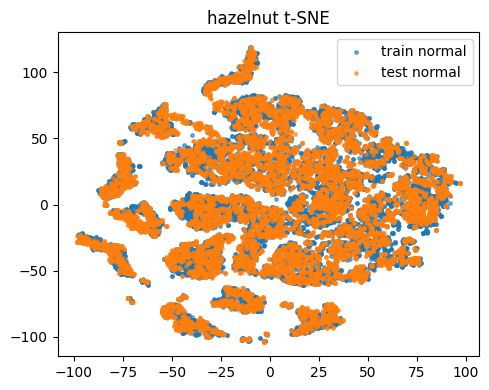

In [29]:
# tsne_plot(Xtr_s, Xte_s, title=f"{target_cls} t-SNE")

- sampling이 아닌 전체 데이터에 대한 시각화가 필요해 보임

/opt/conda/envs/patchcore/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


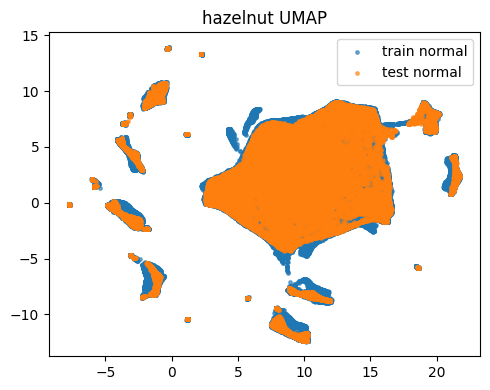

In [30]:
umap_plot(Xtr, Xte, title=f"{target_cls} UMAP")

In [31]:
compute_shift_metrics(Xtr, Xte)

{'MMD': 1.0276820506935404e-09, 'FID': 77.0228271484375}

## **4-2. 전체 실행**